# **Music Performance During the Coronavirus: LGBM**

In [18]:
import numpy as np, pandas as pd, os, sys, itertools, re, warnings, math, scipy as sp, lightgbm as lgb, sklearn, shap, matplotlib.pyplot as plt, matplotlib.cm as cm, statsmodels.stats.api as sms, statsmodels.api as sm
from sklearn import preprocessing, metrics, manifold
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer, confusion_matrix, plot_confusion_matrix, classification_report 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from IPython.display import Image, HTML
from matplotlib.ticker import NullFormatter

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline
plt.rcParams['figure.figsize'] = (14,4)
warnings.filterwarnings(action='ignore')
os.chdir("/Users/home/Desktop/Research/Coronavirus/Public GitHub/")
%run Coronavirus_Music_Functions.ipynb

### **Data**

In [19]:
with open("/Users/home/Desktop/Research/Coronavirus/Public GitHub/cleaned_data.csv", encoding="utf8", errors='ignore') as file:
    all_data = pd.read_csv(file)
all_data = all_data.drop(columns = ['Unnamed: 0','ID'], axis = 1).reset_index(drop=True)
    
no_listening = [string for string in all_data.columns if not any(substring in string for substring in ['Music Listening', 'Formats'])]
all_data = all_data[no_listening].reset_index(drop=True)
all_data = all_data.reindex(sorted(all_data.columns), axis=1)

# drop individuals who did not complete the performance portion or answer the hypotheses
performance_list = [c for c in all_data.columns if 'Making Music' in c]
data = all_data.dropna(subset=performance_list, how='all').reset_index(drop = True)

h_list = ['_Feel Connected to Others', '_Helps Me Cope', '_Serve as Social Interaction']
h_cols = [c for c in data.columns if any(h in c for h in h_list)]
data = data.dropna(subset=h_cols, how='any').reset_index(drop = True)
data.columns = data.columns.str.replace("Making Music_", "")
data = data.rename(columns={"Country_Country Name": "Country"})
old_columns = data.columns.tolist()

# remove columns with more than 20% missing data
data = remove_columns(data, 20)
new_columns = data.columns.tolist()
columns_with_missing_data = set(old_columns) - set(new_columns)
print(columns_with_missing_data)

# impute missing values by country
normalize_column = 'Country'
cols_to_impute = [x for x in data.columns if x != normalize_column]

for i, column in enumerate(cols_to_impute):
    data[column] = data.groupby(normalize_column, sort = False)[column].apply(lambda x: x.fillna(x.median()))
    
data.reset_index(inplace = True, drop = True)

1.2 percent of cols with > 20 % missing data
{'Demographics_Health_Bored'}


In [20]:
# average hypotheses columns
hypotheses = ['Hypotheses_Feel Connected to Others', 'Hypotheses_Helps Me Cope', 'Hypotheses_Serve as Social Interaction']

cor = data[hypotheses].corr().unstack().sort_values(kind="quicksort", ascending = False)
cor = pd.DataFrame(cor)
cor.columns = ['correlation']
print(cor[cor.correlation < 1], "\n")

data['avg_h'] = (data.loc[:,hypotheses]).mean(axis=1)

print(100*(len(data.loc[data['avg_h'] > 4,:])/len(data)), "% of people who scored > 4")
data = data.drop(columns = ['Hypotheses_Feel Connected to Others', 'Hypotheses_Helps Me Cope', 
                            'Hypotheses_Serve as Social Interaction'], axis = 1).reset_index(drop = True)

data['Country'] = data.Country.astype('category').cat.codes
h_avg = data.pop('avg_h')

                                                                               correlation
Hypotheses_Helps Me Cope               Hypotheses_Feel Connected to Others        0.741498
Hypotheses_Feel Connected to Others    Hypotheses_Helps Me Cope                   0.741498
Hypotheses_Serve as Social Interaction Hypotheses_Feel Connected to Others        0.732678
Hypotheses_Feel Connected to Others    Hypotheses_Serve as Social Interaction     0.732678
Hypotheses_Serve as Social Interaction Hypotheses_Helps Me Cope                   0.726054
Hypotheses_Helps Me Cope               Hypotheses_Serve as Social Interaction     0.726054 

56.94729637234771 % of people who scored > 4


#### **Linearity Assumptions**

In [4]:
# Multicollinearity
X = data.copy()
X = sm.add_constant(X)
y = h_avg

vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
len(vif[vif > 5]), vif[vif > 5]

(25,
 Country_City Type-No Response                                                inf
 Country_City Type-Rural                                                      inf
 Country_City Type-Suburban                                                   inf
 Country_City Type-Urban                                                      inf
 Demographics_COVID_Work Changed Binary                                  5.145378
 Demographics_General_Employement Before COVID-Employed Full Time             inf
 Demographics_General_Employement Before COVID-Employed Part Time             inf
 Demographics_General_Employement Before COVID-Home Maker Caregiver           inf
 Demographics_General_Employement Before COVID-Not Employed                   inf
 Demographics_General_Employement Before COVID-Prefer Not To Say              inf
 Demographics_General_Employement Before COVID-Retired                        inf
 Demographics_General_Employement Before COVID-Self Employed                  inf
 Demographi

In [5]:
avg_ols_model = sm.OLS(y, X)
avg_results = avg_ols_model.fit()
avg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  avg_h   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     23.99
Date:                Wed, 04 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:09:19   Log-Likelihood:                -4290.6
No. Observations:                2922   AIC:                             8885.
Df Residuals:                    2770   BIC:                             9794.
Df Model:                         151                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================================
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
const                                                                  -0.3272      0.388     -0.843      0.399      -1.088       0.433
Activities_Call People                                                 -0.0052      0.017     -0.301      0.764      -0.039       0.029
Activities_Cleaning                                                     0.0098      0.018      0.540      0.589      -0.026       0.045
Activities_Cooking                                                     -0.0039      0.018     -0.216      0.829      -0.040       0.032
Activities_Crafting                                                     0.0029      0.017      0.167      0.867      -0.031       0.037
Activities_Create Online Content                                       -0.0227      0.019     -1.222      0.222      -0.059       0.014
Activities_Drugs or Alcohol                                             0.0152      0.018      0.851      0.395      -0.020       0.050
Activities_Exercise Indoors                                            -0.0306      0.016     -1.909      0.056      -0.062       0.001
Activities_Exercise Outdoors                                           -0.0010      0.014     -0.071      0.944      -0.028       0.026
Activities_Fashion                                                      0.0188      0.015      1.248      0.212      -0.011       0.048
Activities_Gardening                                                    0.0096      0.018      0.539      0.590      -0.025       0.045
Activities_Learning New Skills                                          0.0239      0.018      1.361      0.174      -0.011       0.058
Activities_Making Music                                                 0.0143      0.018      0.816      0.415      -0.020       0.049
Activities_Meditating                                                  -0.0019      0.018     -0.101      0.920      -0.038       0.034
Activities_Online Dating                                               -0.0234      0.019     -1.234      0.217      -0.061       0.014
Activities_Photography                                                 -0.0090      0.017     -0.521      0.603      -0.043       0.025
Activities_Playing Games                                               -0.0165      0.017     -0.957      0.339      -0.050       0.017
Activities_Reading Books                                                0.0063      0.018      0.354      0.723      -0.029       0.041
Activities_Searching for Music Info                                    -0.0044      0.019     -0.226      0.821      -0.042       0.033
Activities_Sexual Activity                                              0.0037      0.017  

0.9666822319776305


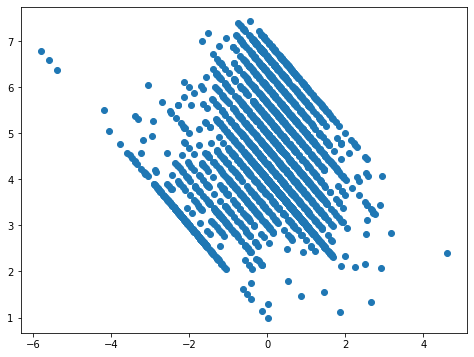

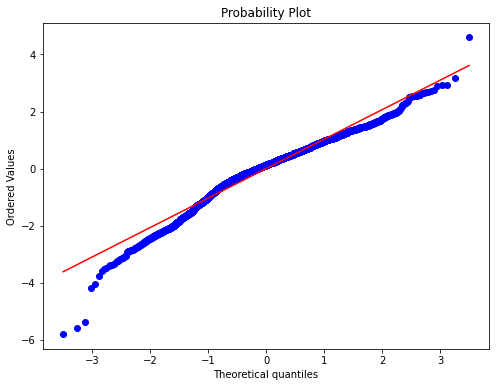

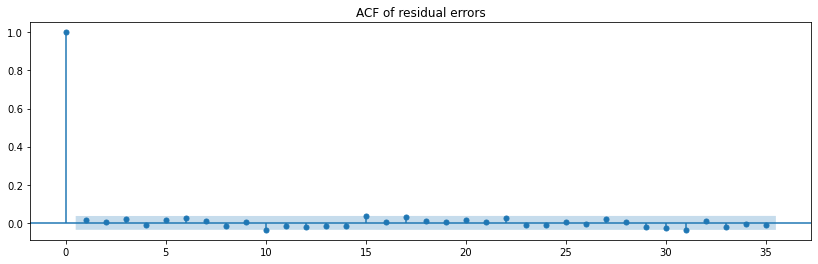

In [6]:
# Normality and autocorrelation of residuals
pred_val = avg_results.fittedvalues.copy()
true_val = y.values.copy()
residual = true_val - pred_val

fig, ax = plt.subplots(figsize=(8,6))
_ = ax.scatter(residual, pred_val)

fig, ax = plt.subplots(figsize=(8,6))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)

print(r**2)

plot_acf(avg_results.resid, title='ACF of residual errors')
plt.show()

In [7]:
# Data are normally distributed: Jarque-Bera
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(avg_results.resid)
lzip(name, test)

[('Jarque-Bera', 464.1788118882067),
 ('Chi^2 two-tail prob.', 1.6026979826473007e-101),
 ('Skew', -0.7128239185609682),
 ('Kurtosis', 4.334198343951924)]

In [8]:
# Heteroskedasticity: Breush-Pagan test
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(avg_results.resid, X)
lzip(name, test)

[('Lagrange multiplier statistic', 248.9046805752633),
 ('p-value', 5.263408823932845e-06),
 ('f-value', 1.7081320431460953),
 ('f p-value', 3.721709851595646e-07)]

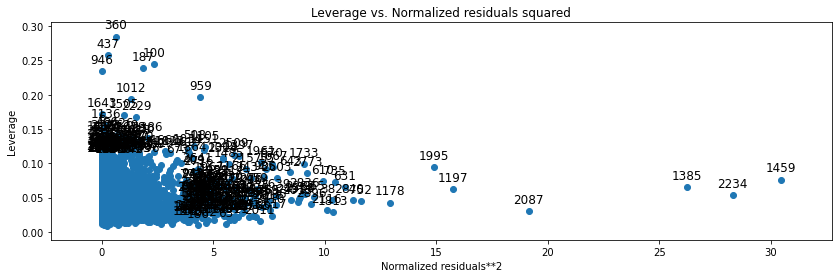

In [9]:
# Leverage/Outliers
sm.graphics.plot_leverage_resid2(avg_results)
plt.show()

#### **LightGBM**

In [10]:
dv = h_avg
h_avg_lgbmr = lgbmr_model(dv, data)

0.0 % of correlations > 0.90

Best parameters found by grid search are: LGBMRegressor(learning_rate=0.05, max_depth=30, min_child_samples=10,
              num_leaves=40, random_state=123, subsample_for_bin=500)

LightGBM Regression_r2: 0.4408
LightGBM Regression_Mean_squared_error: 1.3106
LightGBM Regression_Mean_absolute_error: 0.8355


### **SHAP Plots**
https://github.com/slundberg/shap/blob/master/README.md

SHAP: average of marginal contributions across all permutations. 

In [11]:
# load JS visualization code to notebook
shap.initjs()

regressor = h_avg_lgbmr
X = data.copy()

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X)

**Mean absolute value of the SHAP values for each feature to get a standard bar plot**

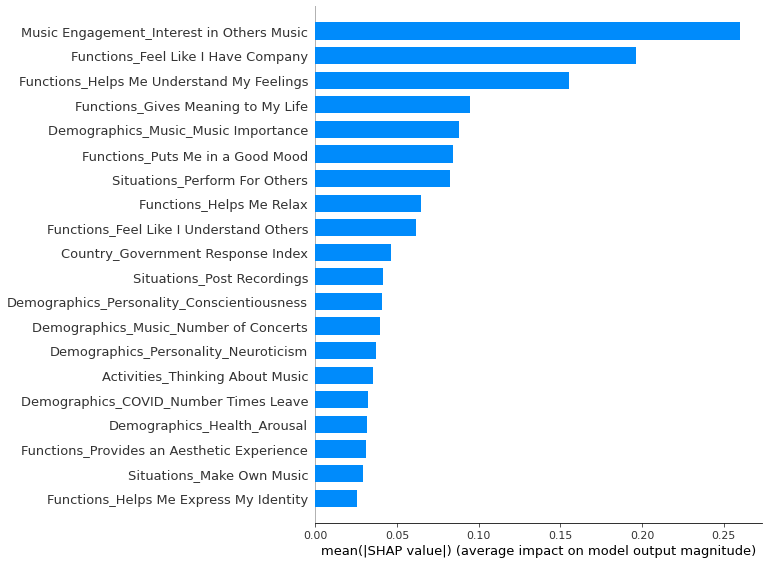

In [12]:
# Simple Feature Importance
shap.summary_plot(shap_values, X, plot_type="bar")

**To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot above sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the 
impacts each feature has on the model output. The color represents the feature value (red high, blue low).**

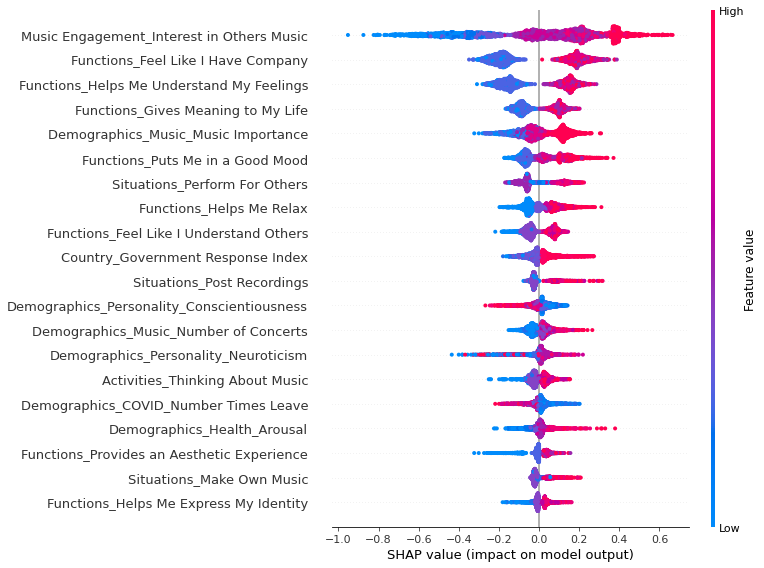

In [13]:
# Shap plot -- summarize the effects of ALL features
shap.summary_plot(shap_values, X)